In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
def gaussian_surface(batch):
    #batch is 32x2
    
    batchout = np.zeros((32, 3))
    batchout[:, 0] = batch[:, 0]
    batchout[:, 1] = batch[:, 1]
    batchout[:, 2] = 40*np.exp(-1.0*np.sum(np.square(batch), axis=1))
    return batchout

def path_energy(path, dt):
    '''
    J: jacobian
    path: Npts x 2
    '''
    npts, _ = np.shape(path)
    #map path through decoder:
    PTS = np.empty((0, 3))
    for batchnum in (range(int(npts / 32))):
        batchpts = pts[batchnum*32:batchnum*32+32]
        batchPTS = gaussian_surface(batchpts)
        PTS = np.vstack((PTS, batchPTS))
        
    diff = PTS[1:, :] - PTS[0:-1, :]
    sq = np.einsum('ik,ik', diff, diff) / (2*dt)
    return sq

def runmodel(pts):
    npts, _ = np.shape(pts)
    #map path through decoder:
    PTS = np.empty((0, 3))
    for batchnum in (range(int(npts / 32))):
        batchpts = pts[batchnum*32:batchnum*32+32]
        batchPTS = gaussian_surface(batchpts)
        PTS = np.vstack((PTS, batchPTS))
    return PTS

def path_gradient(path, dx, dt):
    ''' 
    compute the energy gradient at the points on the path
    '''
    npts = np.shape(path)[0]
    pts = np.zeros((5*npts, 2))
    jac = np.zeros((npts, 3, 2))
    for ind, point in enumerate(path):
        pts[ind*5:(ind*5+5), :] = [[point[0]+dx, point[1]],
                                   [point[0]-dx, point[1]],
                                   [point[0], point[1]+dx],
                                   [point[0], point[1]-dx],
                                   [point[0], point[1]]]
          
    vals = runmodel(pts)
    for ind, point in enumerate(path):
        jac[ind, :, 0] = (vals[5*ind, :] - vals[5*ind+1, :])/(2*dx)
        jac[ind, :, 1] = (vals[5*ind+2, :] - vals[5*ind+3, :])/(2*dx)
        
    
    # path vecs
    G = vals[4::5, :]
    g = G[2:, :] + G[0:-2, :] - 2*G[1:-1, :]
    grad = -1.0*np.einsum('ijl,ij->il', jac[1:-1, :, :], g)/dt
    diff = vals[1:, :] - vals[0:-1]
    E = np.einsum('ik,ik', diff, diff) / dt
    
    return (grad, E)
    
def minimize_path(path, nsteps, alpha, dt):
    npts = path.shape[0]
    paths = np.empty((0, npts, 2))
    Eold = 100000.0
    E = 0
    step = 0
    while step < nsteps and abs(Eold-E) > 0.000001:
        Eold = E
        (grad, E) = path_gradient(path, 0.0001, dt)
        if not np.mod(step, 1000):
            print('Energy: ', E)
            paths = np.vstack((paths, np.copy(path)[np.newaxis, :, :]))
        path[1:-1, :] -= alpha*grad
        step +=1
        
    print(step)
    print(E, Eold)
    return (path, paths)

path = np.random.randn(32, 2)
pt0 = np.array([-2.0, 0.0])
pt1 = np.array([2.0, 0.01])
ts, dt = np.linspace(0, 1, 256, retstep=True)
path = np.array([pt0+a*(pt1-pt0) for a in ts])
print(path.shape)
init_path = np.copy(path)

(256, 2)


In [ ]:
path, paths = minimize_path(path, 200000, 0.0001, dt)

Energy:  8131.55253761
Energy:  9805.25949099
Energy:  4813.62427716
Energy:  3370.352218
Energy:  2906.32812687
Energy:  3006.44117241
Energy:  1996.05242063
Energy:  1801.48812883
Energy:  1847.17352804
Energy:  1521.78896207
Energy:  1326.06901381
Energy:  1209.83288071
Energy:  1178.15713545
Energy:  1018.12145967
Energy:  941.541629265
Energy:  1165.25155607
Energy:  847.850826684
Energy:  781.096351903
Energy:  780.017707033
Energy:  774.642666858
Energy:  658.767758496
Energy:  665.605984036
Energy:  587.475700392
Energy:  561.38821468
Energy:  542.215243562
Energy:  723.891459597
Energy:  798.784078916
Energy:  473.58275217
Energy:  443.774119029
Energy:  493.808164728
Energy:  409.160708954
Energy:  391.064439284
Energy:  393.606195714
Energy:  372.702482503
Energy:  367.619245477
Energy:  492.330940134
Energy:  533.958296003
Energy:  349.23196457
Energy:  462.236144958
Energy:  375.190289693
Energy:  285.455281673
Energy:  289.817464761
Energy:  272.873728151
Energy:  260.652

<IPython.core.display.Javascript object>


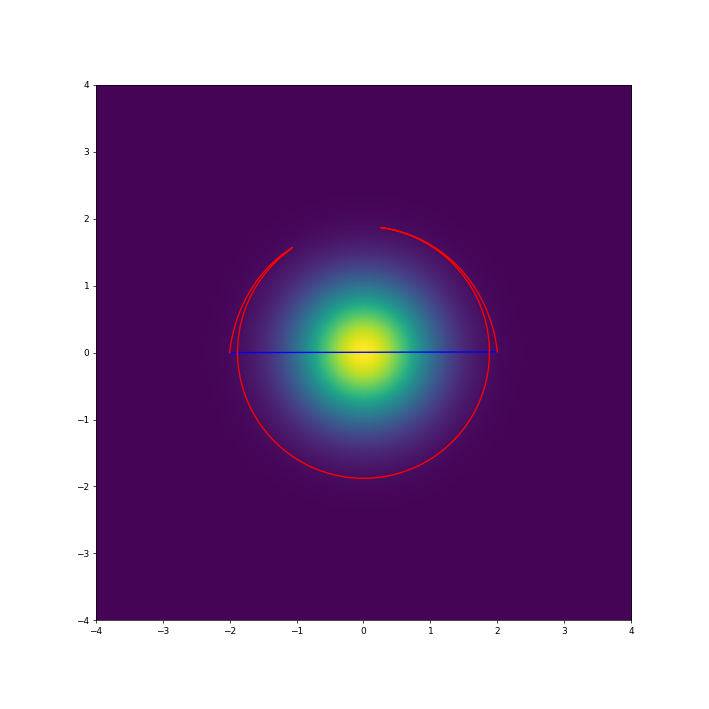

(-4, 4)

In [148]:
#print(path - init_path)
X, Y = np.meshgrid(np.linspace(-5, 5, 1024), np.linspace(-5, 5, 1024))
Z = 40*np.exp(-1.0*(np.square(X)+np.square(Y)))
plt.figure(figsize=(11,11))
plt.plot(init_path[:, 0], init_path[:, 1], 'b')
plt.plot(path[:, 0], path[:, 1], 'r')
plt.imshow(Z, alpha=0.99, extent=[-5, 5, -5, 5])
plt.xlim([-4, 4])
plt.ylim([-4, 4])

(-4, 4)

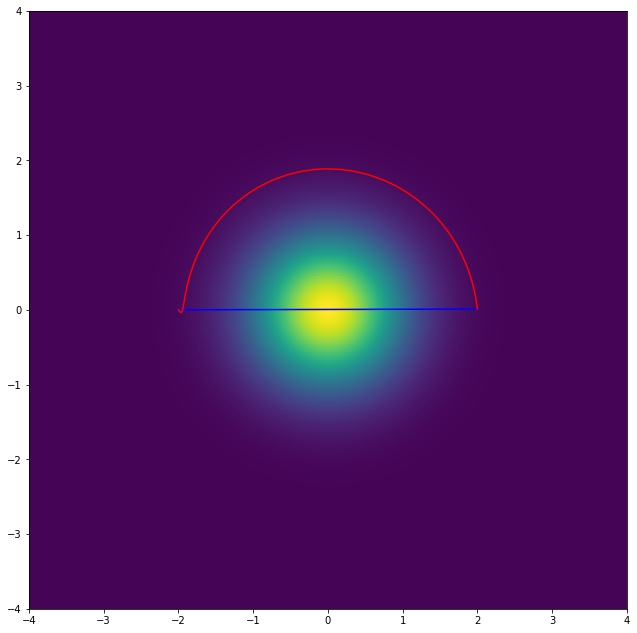

In [114]:
#print(path - init_path)
X, Y = np.meshgrid(np.linspace(-5, 5, 1024), np.linspace(-5, 5, 1024))
Z = 40*np.exp(-1.0*(np.square(X)+np.square(Y)))
plt.figure(figsize=(11,11))
plt.plot(init_path[:, 0], init_path[:, 1], 'b')
plt.plot(path[:, 0], path[:, 1], 'r')
plt.imshow(Z, alpha=0.99, extent=[-5, 5, -5, 5])
plt.xlim([-4, 4])
plt.ylim([-4, 4])

<IPython.core.display.Javascript object>


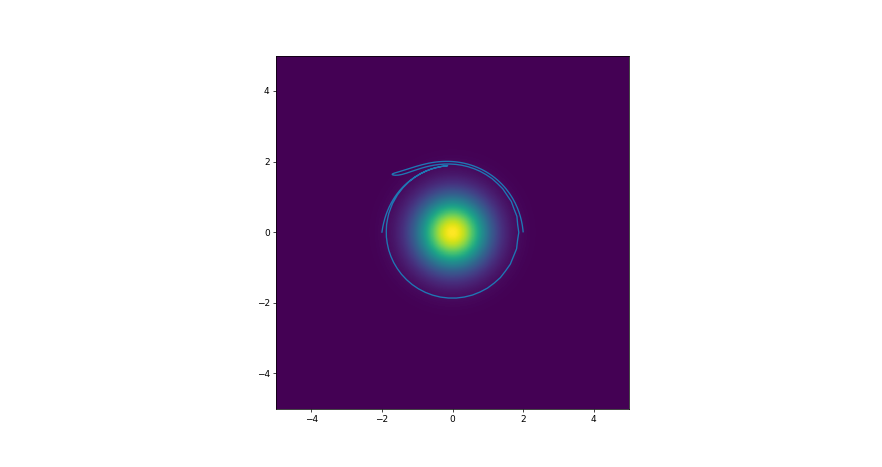

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
fig, ax = plt.subplots()

line, = ax.plot(paths[0, :, 0], paths[0, :, 1])
nt = paths.shape[0]
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.imshow(Z, extent=[-5, 5, -5, 5])


def animate(i):
    line.set_ydata(paths[i, :, 1])  # update the data
    line.set_xdata(paths[i, :, 0])
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(paths[0, :, 1], mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, nt), init_func=init,
                              interval=25, blit=True)
plt.show()